# cs8321 Lab 1 - ConceptNet Ethics Testing

#### Chip Henderson - 48996654


### Overview of Bias Investigation

The topic ageism has never been more prominent than it is today. The 2024 presidential election will see at least two candidates that would be in their 80's at the end of their terms, leading to overarching narratives and concern on their ability to perform the role of president. However, ageism is nothing new. "The term ageism was coined in 1968 by Robert Butler—a Pulitzer Prize winning gerontologist who founded the National Institute on Aging. Dr. Butler described ageism as a process of systematic stereotyping and discrimination against people because they are old" (Butler, 1969). Further, a Harvard Business Review article titled "Am I Old Enough to Be Taken Seriously?" (Waldman, 2020) states that the most common form of ageism found in the workplace is reverse ageism, the discrimination against workers because of their youth.

With the advent of Large Language Models (LLMs) as a form of generative Artificial Intelligence (AI) in the workplace, it is appropriate to explore and understand how particular models may impart ageism on their generated results. This type of discrimination could manifest itself, albeit unintentionally, in workplace related content that perpetuates these beliefs. Additionally, the ability of LLMs to quicky generate content that can flood websites and unreliable news outlets needs to be accounted for so that it can be understood and mitigated.

### Research Question and Hypothesis

This notebook intends to explore the pervasiveness of ageism in various embedding models. Beyond simply measuring the sentiment of age related nouns present in an particular embedding model, I will seek to demonstrate ageism is not necessarily the caused directly via training of the embedding's models, but of the sentiment of words in most common usage, and therefore a human linguistic problem.

To do this, I'll utilize similar investigative styles presented in SMU CS8321 course notebook 01 ConceptNet. This will include the same data and sources for lexicon and embedding models. However, I will introduce unigram frequency data provided by Kaggle to assist in showing that given the selection of different words, the presence of ageism is reduced. Therefore, if ageism bias is known to exist it can be directly mitigated through word substitution.

### Analysis and Model Training

I'll start by importing the same datasets used in the 01 ConceptNet notebook from class. 

In [393]:
# Uncomment for use in colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [394]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import display, Math

In [395]:
%%time
# Source: cs8321 notebook 01 ConceptNet
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('data/glove.840B.300d.txt') # course original
# embeddings = load_embeddings('../Data_Sources/numberbatch-en.txt') # local PC
# embeddings.shape

CPU times: total: 0 ns
Wall time: 0 ns


In [396]:
# Source: cs8321 notebook 01 ConceptNet
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.

    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

# For running on local system, use the following:
pos_words = load_lexicon('../Data_Sources/positive-words.txt')
neg_words = load_lexicon('../Data_Sources/negative-words.txt')

# For running in colab, use the following:
# pos_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/positive-words.txt') # colab version
# neg_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/negative-words.txt') # colab version

print(len(pos_words), len(neg_words))

2006 4783


I'll add frequency of use data now provided by Kaggle.

In [397]:
# Source: https://www.kaggle.com/datasets/rtatman/english-word-frequency?resource=download

word_frequency_df = pd.read_csv(r'../Data_Sources/unigram_freq.csv')
word_frequency_df.head()

,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698


The data in this dataset is comprised of "333,333 most commonly-used single words on the English language web as derived from the Google Web Trillion Word Corpus." (https://www.kaggle.com/datasets/rtatman/english-word-frequency)

Let's create some groupings for different ages. Selecting words for this research can be challenging. I want to focus primarily on using nouns and not adjectives. However, many words have multiple meanings and can have multiple Parts of Speech (PoS). Take the word "old" for example. It can be both a noun, referring to a group of people, and an adjective, describing the age of a person. I want to avoid these words as they connotate negativity with disproportionate frequency than their opposites. It wouldn't be uncommon to describe your car as old, and one can assume it is done with some frequency. It would be odd, however, to describe your car as young as this word is typically reserved for referring to living things. So the term young may occur with less frequency as it tends to only apply to a particular subset of words.

Let's see if that's plausible with the words "young" and "old."

In [398]:
print(word_frequency_df[word_frequency_df['word'] == 'young'])
print("\n")
print(word_frequency_df[word_frequency_df['word'] == 'old'])

      word      count
570  young  136341684


    word      count
370  old  199694226


As expected, the word "old" occurs with greater frequency than the word "young." This highlights the challenges in developing a significantly robust evaluation set for this subject.

I'm going to make 4 very general groups to contain my age related nouns. These will consist of
 -  Young: Describing those before teenage years
 -  Teen: Describing those within their teenage years
 -  Adult: Describing post teenage maturity
 -  Old: Describing generally those at retirement age, mid 60's and beyond

To differentiate between the "young" and "teen" categories I am defering any terms not specific to childhood to be "Teen" terms. Therefore words like "toddler" apply to the young category and words like "minor" apply to the "Teen" category. The groupings are guided by the National Library of Medicine, "Ericksons Stages of Psychosocial Development" (Orenstein, Lewis, 2022) referenced in the next block.

In [399]:
# source:https://www.britannica.com/dictionary/eb/qa/Age-by-Decade#:~:text=A%20person%20between%2020%20and,59%20is%20called%20a%20quinquagenarian.
# source: https://www.ncbi.nlm.nih.gov/books/NBK556096/
# source: https://langeek.co/en/vocab/subcategory/900/word-list
'''
There are a lot of words that can be used to describe different stages of life.
I'm going to use the national library of medicine to define some of these groupings.
There are also a lot of words with multiple meanings and attemptint to not
unintentionally skew the data can be challenging. It's hard to stay away from 
adjectives which by definition describes or defines a noun and thereby imparting
sentiment. Some words are both nouns and adjectives, like juvenile.
'''
AGE_BY_CATEGORY = {

    'Young': [
        'infant','child','toddler','preschooler','girlhood','new','baby','youngling',
        'youth','neonate','preteen','boyhood','young','newborn','kid','tyke',
        'tween'
        ],
    'Teen': [
        'teenager','minor','juvenile','teen','stripling','youngster',
        'adolescent','fledgling','adolescence','pubescent','junior'
        ],
    'Adult': [
        'vicenarian','tricenarian','adult','quadragenarian','sexagenarian',
        'manhood','womanhood','maturity','quinquagenarian','prime'
        ],
    'Old': [
        'retiree','elder','experienced','geriatric', 'centenarian','oldster',
        'octogenarian','nonagenarian','septuagenarian','senior','pensioner'
        ]
}

With only 333,333 words in my frequency dataframe, I'd like to see which of my listed words do not appear. If they do not appear, it is safe to assume they were not found as part of the corpus of frequently used words and therefore would occur somewhere beyond 333,333. To account for these, I'll append them to the dataset in no specific order past 333,333.

In [400]:
# Get a list of my nouns that might not be in the frequency data
infrequent_words = []
for group, noun_list in AGE_BY_CATEGORY.items():
    for noun in noun_list:
         if word_frequency_df[word_frequency_df['word'] == noun].empty:
            infrequent_words.append(noun)

# Append the new nouns to the frequency data
# I'll separate each word by an arbitrary value 1 for the count decreasing.
# First, let's get the very last count value in the current data:
last_count = word_frequency_df['count'].iloc[-1]

# Now let's append some data after that value
infrequent_df = pd.DataFrame(columns=['word','count'])
infrequent_counts = []
infrequent_dict = {}
for i, word in enumerate(infrequent_words):
    infrequent_counts.append(last_count-i)

infrequent_dict['word'] = infrequent_words 
infrequent_dict['count'] = infrequent_counts
infrequent_df = pd.DataFrame.from_dict(infrequent_dict)

# Concatenate the infrequent words with the frequent ones
word_frequency_df = pd.concat([word_frequency_df,infrequent_df], ignore_index=True)

word_frequency_df.tail(len(infrequent_words))

,word,count
333333,youngling,12711
333334,vicenarian,12710
333335,tricenarian,12709
333336,quadragenarian,12708
333337,sexagenarian,12707
333338,quinquagenarian,12706
333339,oldster,12705
333340,nonagenarian,12704


### Training the model

First, I'm going to be copying some of the functions from the ConceptNet notebook from class to make processing the model training earlier. I'll take the functions that captured sentiments for each word as well as the code that built the Lexicon and vector dataframes. I'm going to modify a few aspects of the functions to make them work with my data.

In [401]:
# Source: Modified from cs8321 01 ConceptNet notebook
# I'm adjusting these functions to reference by age related dictionary
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


def age_sentiment_table():
    frames = []
    # for group, age_list in sorted(AGE_BY_CATEGORY.items()):
    for group, age_list in AGE_BY_CATEGORY.items():
        lower_names = [name.lower() for name in age_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [402]:
# Source: Modified from cs8321 01 ConceptNet notebook
# I'm splitting out the plotting functions so I can access them directly
import scipy.stats as stats

def retrain_model_age(new_embs, title = ''):
    # use these from outside the function and update them globally
    global model, embeddings, age_sentiments
    embeddings = new_embs
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index)) 
    neg_words_common = list(set(neg_words) & set(embeddings.index)) 
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
    
    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)
    
    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    
    # get the name table of different people's names and save embeddings
    age_sentiments = age_sentiment_table()
    age_sentiments = pd.merge(age_sentiments, word_frequency_df, left_index=True, right_on='word')

    return(age_sentiments)

Now, let's train our model for the first time using the NumberBatch data and lexicon loaded previously.

In [403]:
# Local PC version
# retrain_model_age(load_embeddings('../Data_Sources/numberbatch-en.txt'), title='ConceptNet Numberbatch')
nb_results = retrain_model_age(load_embeddings('../Data_Sources/numberbatch-en.txt'), title='ConceptNet Numberbatch')

# Colab version
# retrain_model(load_embeddings('/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt'), title='ConceptNet Numberbatch')

Accuracy of sentiment: 96.99%


### Analysis

Because I'm going to be introducing a second numeric value to my data in the form of frequency, I want to make sure the data is plotted on the same scale. Therefore I'm going to normalize my data. 

In [404]:
# Source: ChatGPT for applying standard scaling
from sklearn.preprocessing import MinMaxScaler

# Assign the scaler object to a variable
scaler = MinMaxScaler()

# Apply fit-transform function to the data of interest
nb_results['sentiment_norm'] = scaler.fit_transform(nb_results[['sentiment']])
nb_results['frequency_norm'] = scaler.fit_transform(nb_results[['count']])

# We could drop the original values now, but there aren't a ton of columns. 
# So, I'll just keep everything.
nb_results.head()

,sentiment,group,word,count,sentiment_norm,frequency_norm
5081,-0.860151,Young,infant,12959639,0.380721,0.008346
654,-1.077202,Young,child,119747393,0.338949,0.077186
8702,-0.860008,Young,toddler,6223093,0.380748,0.004003
55164,-0.463123,Young,preschooler,281628,0.457129,0.000173
101756,0.959620,Young,girlhood,96165,0.730936,0.000054


In [405]:
# Source: Modified from cs8321 01 ConceptNet notebook
# I'm making the plotting function unique and more dynamic by allowing
# me to specify the values I want to plot. This will be necessary
# to compare my altered data.

def plot_values(title, data, values): # age_sentiments = age_sentiment_table()
    stats.f_oneway(
        data[values][data['group'] == 'Young'],
        data[values][data['group'] == 'Teen'],
        data[values][data['group'] == 'Adult'],
        data[values][data['group'] == 'Old'],
    )

    fstat,pval = stats.f_oneway(
        data[values][data['group'] == 'Young'],
        data[values][data['group'] == 'Teen'],
        data[values][data['group'] == 'Adult'],
        data[values][data['group'] == 'Old'],
    )
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y=values, data=data)
    plot.set_ylim([-5, 5])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y=values, data=data, capsize=.1)
    matplotlib.pyplot.suptitle(title, fontsize=16)

Let's take a look at the intial measurements of my ageism sentiments.

F-statistic: 1.4412920317144369  With P-value: 0.24331206496499738


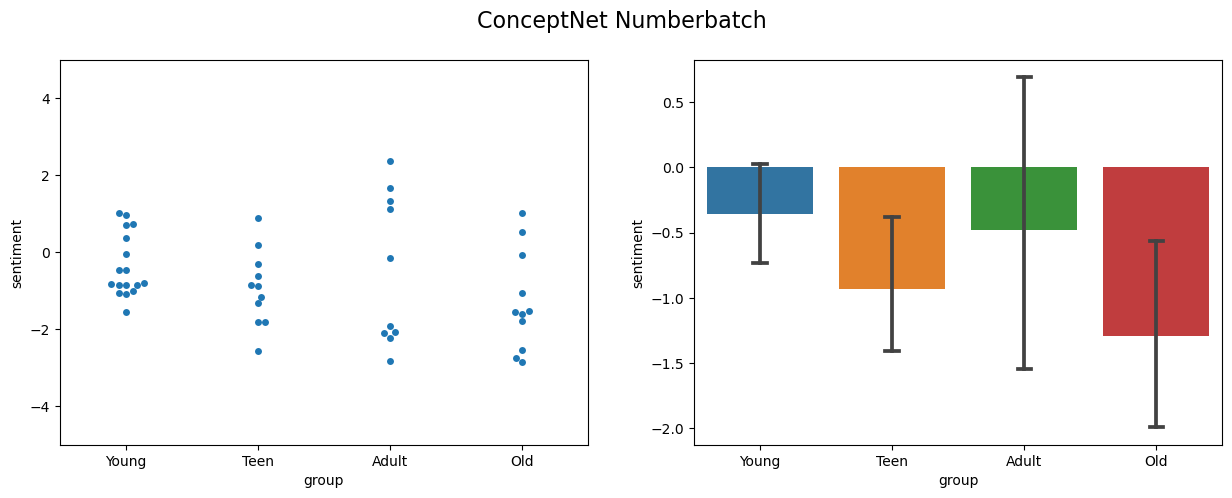

In [406]:
plot_values('ConceptNet Numberbatch',nb_results,values='sentiment')

This initial look at the data shows me that Old and Teen groups tend to have the worst negative sentiments. There is a lot of overalp as well with the adult bar, though it ranges far more into positive territory than the the others. Young is the least negative. Could this data be improved by introducing the word frequency? Could we see more overlap of the error bars and an alignment of mean values?

To bring the frequency count into play, we'll setup a weighted average value and replot.

#### Introduction of Unigram Frequency

Let's add a new value consisting of a weighted average of both frequency and sentiment. I need to answer the question of what weights I assign to each value. Arbitrarily guessing would look like confirmation bias, however this is a proof of concept. What I intend to show that the selection of words in our high frequency vocabulary is driving potential ageism results in machine learning models. That given a different nomenclature the bias can be mitigated. Therefore I won't be basing my weighting values on statistical analysis and will instead be making an educated guess.

Knowing that certain words carry negative sentiment connotation could allow data scientists to mitigate this bias by balancing the impact that synonyms could play in generating results.

I'm going to be using the formula below for weighted average. I want to apply more weight to words less frequently used, so I'll subtract the frequency values from 1 before multiplying by the frequency weight. 

In [407]:
from copy import deepcopy
display(Math(r'\text{Weighted\_average} = (\text{sentiment\_weight} \times \text{sentiment\_value}) + (\text{frequency\_weight} \times (1 - \text{frequency\_value}))'))
nb_results_weighted = deepcopy(nb_results)
# Let's start with weighting the frequency of use twice as high as sentiment
nb_results_weighted['weighted_avg'] = (0.33*nb_results_weighted['sentiment_norm']) + (0.67*(1-nb_results_weighted['frequency_norm']))
# nb_results_weighted['weighted_avg'] = (0.75*nb_results_weighted['sentiment_norm']) + (0.25*(1-nb_results_weighted['frequency_norm']))

nb_results_weighted.head()

<IPython.core.display.Math object>

,sentiment,group,word,count,sentiment_norm,frequency_norm,weighted_avg
5081,-0.860151,Young,infant,12959639,0.380721,0.008346,0.790046
654,-1.077202,Young,child,119747393,0.338949,0.077186,0.730139
8702,-0.860008,Young,toddler,6223093,0.380748,0.004003,0.792965
55164,-0.463123,Young,preschooler,281628,0.457129,0.000173,0.820736
101756,0.959620,Young,girlhood,96165,0.730936,0.000054,0.911173


Now let's check our results again. I'll plot the two charts right next to each other for easy visual analysis.

F-statistic: 0.3306006225591922  With P-value: 0.8032334686616392
F-statistic: 1.4412920317144369  With P-value: 0.24331206496499738


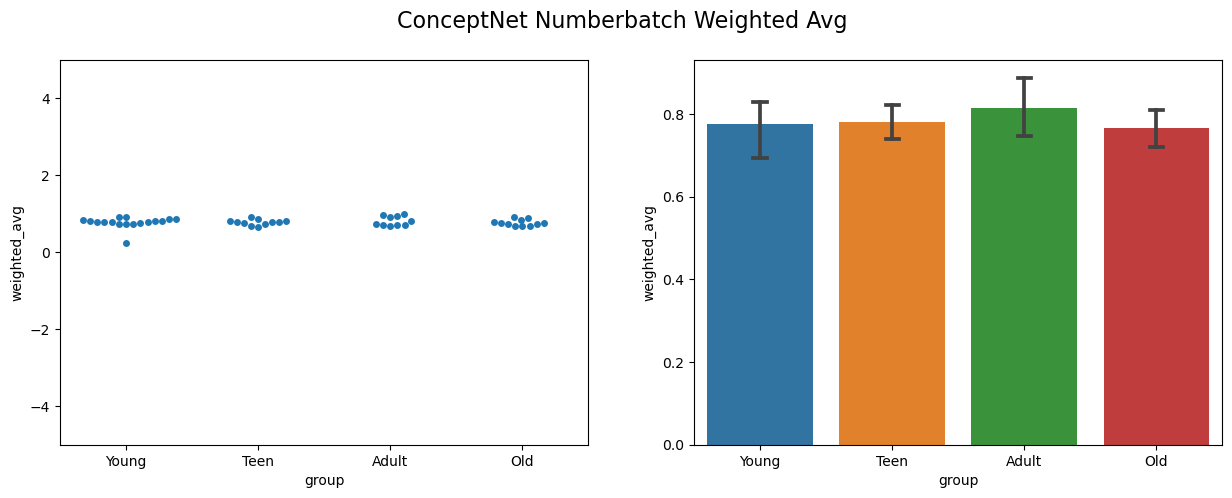

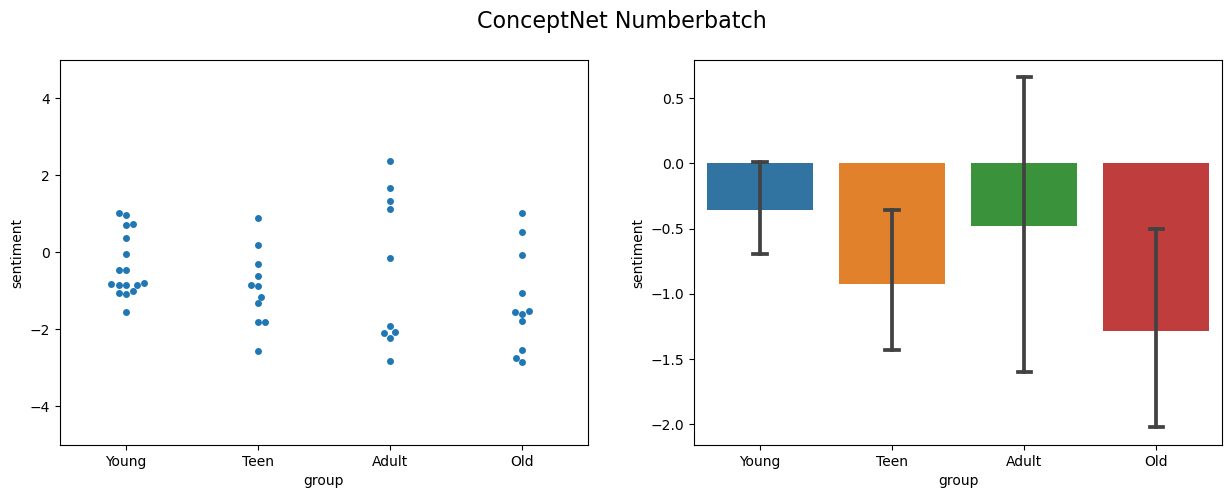

In [408]:
plot_values('ConceptNet Numberbatch Weighted Avg',nb_results_weighted,values='weighted_avg')
plot_values('ConceptNet Numberbatch',nb_results,values='sentiment')

Based on these results, I can see that using a weighted average of unigram frequency and sentiment has allowed me to make it so that all of the error bars share significant overlap. With respect to my research question I can at least visually state that it seems plausible that word substitution would provide mitigaion for ageism bias in ConceptNet numberbatch.

### Statistical Comparison

I don't believe direct statistical comparison is the most appropriate measurement between these two datasets. I'm not comparing the same data directly to one another. In one dataframe I have the pure sentiment values derived from the log_proba function and in the other I have a sentiment weighted average that takes into account frequency of word occurrence. For the sake of completeness I wanted to go ahead and perform this analysis and discuss the results.

In [409]:
# Source: ChatGPT for performing the t-test
from scipy import stats

# Assuming df1 and df2 are your dataframes
# Each dataframe should have columns representing sentiment values and categorical groups

# Group data by category
grouped_df1 = nb_results.groupby('group')
grouped_df2 = nb_results_weighted.groupby('group')

# Perform t-test for each group
for group, data1 in grouped_df1:
    data2 = grouped_df2.get_group(group)
    
    t_statistic, p_value = stats.ttest_ind(data1['sentiment'], data2['weighted_avg'])
    
    print(f"Category: {group}")
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("There is a statistically significant difference in sentiment between the two datasets for this group.\n")
    else:
        print("There is no statistically significant difference in sentiment between the two datasets for this group.\n")



Category: Adult
t-statistic: -2.0939859360056357
p-value: 0.05068373580591861
There is no statistically significant difference in sentiment between the two datasets for this group.

Category: Old
t-statistic: -5.273111639152407
p-value: 3.6804471856233294e-05
There is a statistically significant difference in sentiment between the two datasets for this group.

Category: Teen
t-statistic: -5.829634875671074
p-value: 1.0546415849333665e-05
There is a statistically significant difference in sentiment between the two datasets for this group.

Category: Young
t-statistic: -5.633573627606267
p-value: 3.1435183481667292e-06
There is a statistically significant difference in sentiment between the two datasets for this group.



Based on the data above I see that the only grouping not indicating statistical difference is my Adult group. This was the group that had the widest 95% confidence interval in the initial plots. Therefore I believe this is at least partially why I don't have a statistically significant difference. 

As a data scientist or machine learning practicioner trying to prove the viability of word substitution as a means of mitigating bias I would want to keep my groupings statistically unaltered by the implementation of the weighted average. This would ensure that I haven't altered the results by applying the mitigation technique. The data above seems to indicate that alteration has occurred. While I can say that visually I have accomplished my task of aligning all bias to be equal across my groupings, I believe more effort is needed on the statistical analysis side to prove the hypothesis completely.

### Recommended Scientific Journals and Conferences

I believe research in this area would be of interest to the following:
 -  AI, Ethics, and Society (AIES): https://www.aies-conference.com/2023/
    -  This organization is supported by many of the larger names in AI and machine learning such as Google, Sony, IBM, and many others. Their focus on ethics and society make them an excellent target for this type of research
 -  The AI Rpbotics Ethics Society (AIRES): https://www.theaires.org/
    -  AIRES has an ethics journal as well as conferences throughout the year. There are chapters representing their interests at major US universities including Cornell, UCLA, USCE, Caltech, Brown, and Stanford.
    -  Their mission is to focus on educating tomorrow's AI leaders in ethical AI principles to ensure AI is created ethically and responsibly.



### Conclusions

I set out to examine whether something as simple as substitution could be a method to tame ethical concerns of ageism in machine learning models. However the concept doesn't necessarily need to stop at ageism. It's a concept that could potentially work across areas of concern. When machine learning models are trained on common text, they inherently "learn" preexisting biases with the most common words and their context. However, if we take synonyms of less frequent use, and substitue them for the trained word, we have an opportunity to mitigate biases and still achieve the desired end result. 

In this notebook I showed that it is possible to put together the components necessary to align sentiment values, and to use unigram frequency to create this alignment across groups. I had wanted to pull in more data samples using several embedding models, however I was continuously faced with some words not being available across all models which would have forced me to continually create a customized set of age related nouns, thereby negating meaningful comparison across models. I believe this is an interesting area that warrants further consideration.